https://github.com/huggingface/peft/blob/main/examples/fp4_finetuning/finetune_fp4_opt_bnb_peft.py

In [1]:
from torch import optim
import lightning as pl
from matplotlib import pyplot as plt

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import warnings
from peft import LoraConfig, get_peft_model, IA3Config

In [3]:
plt.style.use('seaborn-v0')
torch.set_float32_matmul_precision('medium')
warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [4]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [5]:
# model_name = "TheBloke/phi-2-GPTQ"
model_name = "microsoft/phi-2"

def load_model():

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        # quantization_config=BitsAndBytesConfig(
        #     load_in_4bit=True,
        #     llm_int8_threshold=6.0,
        #     llm_int8_has_fp16_weight=False,
        #     bnb_4bit_compute_dtype=torch.float16,
        #     bnb_4bit_use_double_quant=True,
        #     bnb_4bit_quant_type="nf4",
        # ),
        torch_dtype=torch.float16,
        trust_remote_code=True,
    )


    # config = AutoConfig.from_pretrained(model_name, trust_remote_code=True,)
    # config.quantization_config['use_exllama'] = False
    # config.quantization_config['disable_exllama'] = True
    # model = AutoModelForCausalLM.from_pretrained(
    #     model_name,
    #     torch_dtype=torch.bfloat16,
    #     trust_remote_code=True,
    #     config=config,
    # )
    return model


In [6]:
base_model = load_model()
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True,)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
def reset_model(base_model):
    # peft_config = LoraConfig(
    #     # task_type=TaskType.TOKEN_CLS, 
    #     target_modules=[ "fc2",  "Wqkv",],
    #     inference_mode=False, r=4, lora_alpha=4, 
    #     # lora_dropout=0.1, 
    #     # bias="all"
    # )
    peft_config = IA3Config(
        target_modules=[ "fc2",  "Wqkv", 'out_proj', 'fc1'], 
            feedforward_modules=["fc2", 'fc1', 'out_proj'],
            inference_mode=False,
    )
    model = get_peft_model(base_model, peft_config)
    model.config.use_cache = False
    return model

model = reset_model(base_model)

In [8]:

MAX_LEN = 400

import frontmatter
from pathlib import Path
sample_files = sorted(Path("../samples/").glob('*.md'))
print(sample_files)
samples = [{'f':f, **frontmatter.load(f).to_dict()} for f in sample_files]

for sample in samples:
    assert 'title' in sample, sample['f']
    assert 'content' in sample
samples[0].keys()

[PosixPath('../samples/bletchley_decleration.md'), PosixPath('../samples/cicero_fin1.md'), PosixPath('../samples/disney_appointment.md'), PosixPath('../samples/fake_paper.md'), PosixPath('../samples/fauci_emails.md'), PosixPath('../samples/harvard_announcement_reminders.md'), PosixPath('../samples/how_to_catch_a_liar.md'), PosixPath('../samples/lk-99_end.md'), PosixPath('../samples/lk-99_espanol.md'), PosixPath('../samples/lorem_ipsum.md'), PosixPath('../samples/openai_board_ann.md'), PosixPath('../samples/openai_paper_weak_to_strong.md'), PosixPath('../samples/politics_is_the_mind_killer.md'), PosixPath('../samples/statement_vyKamala_on_passing_of_johnson.md'), PosixPath('../samples/survey_of_rumours.md')]


dict_keys(['f', 'title', 'url', 'content'])

## Helpers

In [9]:
# modified from https://github.dev/huggingface/evaluate/blob/8dfe05784099fb9af55b8e77793205a3b7c86465/measurements/perplexity/perplexity.py#L154
import evaluate
from evaluate import logging
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

def perplexity_compute(
    ds, model, tokenizer, batch_size: int = 16, add_start_token: bool = True, device=None, max_length=None
):
    model = model.to(device)


    ds = ds.with_format('pt')
    dl = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, collate_fn=tokenizer.pad, pin_memory=True)
    ppls = []
    loss_fct = CrossEntropyLoss(reduction="none")
    for b in dl:
        input_ids = b['input_ids'].to(device)
        attention_mask = b['attention_mask'].to(device)
        print(attention_mask)

        labels = input_ids

        with torch.no_grad():
            out_logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

        shift_logits = out_logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_attention_mask_batch = attention_mask[..., 1:].contiguous()

        perplexity_batch = torch.exp(
            (loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_attention_mask_batch).sum(1)
            / shift_attention_mask_batch.sum(1)
        )

        ppls += perplexity_batch.tolist()

    return {"perplexities": ppls, "mean_perplexity": torch.tensor(ppls).mean()}

In [10]:
# perplexity_compute(ds=ds_val, model=model, tokenizer=tokenizer, device='cuda')

## Training

In [11]:
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from datasets import Dataset

## Lightning helpers

In [12]:
def eval(model, tokenizer, ds_val: Dataset):
    model.eval();
    with torch.no_grad():
        with model.disable_adapter():
            results = perplexity_compute(ds=ds_val, model=model, tokenizer=tokenizer, device='cuda')
        results2 = perplexity_compute(ds=ds_val, model=model, tokenizer=tokenizer, device='cuda')
    return dict(before=results['mean_perplexity'].item(), after=results2['mean_perplexity'].item())


# Train

In [13]:
from datasets import Dataset


def compute_metrics(eval_prediction):
    return {}

Trainer docs

- https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer

In [14]:
MAX_LEN, len(sample['content'])//3

(400, 14201)

In [15]:

def tokenize_and_split(examples):
    l = len(tokenizer(examples).input_ids[0])
    max_len = min(l//3, MAX_LEN) # break into at least 5
    max_len = max(max_len, 10)


    result = tokenizer(
        examples,
        # add_special_tokens=False,
        truncation=True,
        stride=2,
        max_length=max_len,
        return_overflowing_tokens=True,
        return_attention_mask=True,
        # return_tensors="pt",
    )
    return result

# s = sample['content']
# first_half = s[:len(s)//2]
# second_half = s[len(s)//2:]
# ds_train = Dataset.from_dict(tokenize_and_split([first_half]))
# ds_val = Dataset.from_dict(tokenize_and_split([second_half]))
# ds_train

In [16]:
from sklearn.model_selection import train_test_split
s = sample['content']

d = Dataset.from_dict(tokenize_and_split([s]))
d2  = d.train_test_split(test_size=0.5, seed=42)
ds_train = d2['train']
ds_val = d2['test']

Token indices sequence length is longer than the specified maximum sequence length for this model (8172 > 2048). Running this sequence through the model will result in indexing errors


In [17]:
os.environ['CUDA_VISIBLE_DEVICES']="1"

In [18]:
def learn_sample(sample):
    # device = 'cuda'
    # lr = 4e-3
    # epochs = 3
    # accum_steps = 1
    batch_size = 1
    verbose = False

    s = sample['content']

    d = Dataset.from_dict(tokenize_and_split([s]))
    d2  = d.train_test_split(test_size=0.5, seed=42)
    ds_train = d2['train']
    ds_val = d2['test']

    
    model = reset_model(base_model)
    # eval(model, tokenizer, ds_train)

    # https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer
    trainer = transformers.Trainer(
        model=model,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        compute_metrics=compute_metrics, # without this it wont even give val loss
        args=transformers.TrainingArguments(
            # checkpoint='epoch',
            save_strategy='epoch',
            label_names=['labels',],
            per_device_train_batch_size=batch_size,
            gradient_accumulation_steps=3,
            warmup_steps=6,
            max_steps=20,
            learning_rate=3e-3,
            fp16=True,
            logging_steps=1,
            output_dir="outputs",
            log_level='error',
            # do_eval=True,
            evaluation_strategy="epoch",
            eval_steps=1,
            load_best_model_at_end=True,
            
            # disable_tqdm=not verbose,
        ),
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )
    trainer._signature_columns = ['input_ids', 'attention_mask', 'labels',]
    model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
    train_output = trainer.train()

    df_hist = pd.DataFrame(trainer.state.log_history)
    df_hist_epoch = df_hist.groupby('epoch').last().drop(columns=['step'])
    df_hist_step = df_hist.set_index('step').dropna(thresh=2, axis=1)
    if verbose:
        df_hist_epoch['loss'].plot()
        plt.twinx()
        df_hist_epoch['eval_loss'].plot(c='b', label='eval')
        plt.legend()
        plt.show()


    result_train = {f'train/{k}':v for k,v in eval(model, tokenizer, ds_train).items()}
    result = eval(model, tokenizer, ds_val)
    result['hist'] = df_hist_epoch
    result.update(result_train)
    return result


In [19]:
data = []
for sample in samples:
    r = learn_sample(sample)
    print(sample['title'])
    print(dict(before=r['before'], after=r['after']))
    data.append(dict(**r, **sample))

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
  0%|          | 0/20 [00:00<?, ?it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
  5%|▌         | 1/20 [00:06<02:03,  6.48s/it]

{'loss': 0.8539, 'learning_rate': 0.0005, 'epoch': 1.0}


                                              
  5%|▌         | 1/20 [00:08<02:03,  6.48s/it]

{'eval_loss': 2.881439447402954, 'eval_runtime': 1.8561, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 10%|█         | 2/20 [00:12<01:46,  5.94s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8546, 'learning_rate': 0.001, 'epoch': 2.0}


                                              
 10%|█         | 2/20 [00:13<01:46,  5.94s/it]

{'eval_loss': 2.875718593597412, 'eval_runtime': 1.8505, 'eval_samples_per_second': 1.081, 'eval_steps_per_second': 0.54, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 15%|█▌        | 3/20 [00:17<01:37,  5.74s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8479, 'learning_rate': 0.0015, 'epoch': 3.0}


                                              
 15%|█▌        | 3/20 [00:19<01:37,  5.74s/it]

{'eval_loss': 2.8696751594543457, 'eval_runtime': 1.8533, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 20%|██        | 4/20 [00:23<01:30,  5.64s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8419, 'learning_rate': 0.002, 'epoch': 4.0}


                                              
 20%|██        | 4/20 [00:24<01:30,  5.64s/it]

{'eval_loss': 2.8617634773254395, 'eval_runtime': 1.8551, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 25%|██▌       | 5/20 [00:28<01:24,  5.61s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.831, 'learning_rate': 0.0025, 'epoch': 5.0}


                                              
 25%|██▌       | 5/20 [00:30<01:24,  5.61s/it]

{'eval_loss': 2.8497085571289062, 'eval_runtime': 1.8556, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 30%|███       | 6/20 [00:34<01:18,  5.59s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.8073, 'learning_rate': 0.003, 'epoch': 6.0}


                                              
 30%|███       | 6/20 [00:36<01:18,  5.59s/it]

{'eval_loss': 2.8383166790008545, 'eval_runtime': 1.8605, 'eval_samples_per_second': 1.075, 'eval_steps_per_second': 0.537, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 35%|███▌      | 7/20 [00:39<01:12,  5.59s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.788, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


                                              
 35%|███▌      | 7/20 [00:41<01:12,  5.59s/it]

{'eval_loss': 2.8310322761535645, 'eval_runtime': 1.8517, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 40%|████      | 8/20 [00:45<01:06,  5.58s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7605, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


                                              
 40%|████      | 8/20 [00:47<01:06,  5.58s/it]

{'eval_loss': 2.8236138820648193, 'eval_runtime': 1.8571, 'eval_samples_per_second': 1.077, 'eval_steps_per_second': 0.538, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 45%|████▌     | 9/20 [00:50<01:01,  5.57s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7438, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


                                              
 45%|████▌     | 9/20 [00:52<01:01,  5.57s/it]

{'eval_loss': 2.818512201309204, 'eval_runtime': 1.8553, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 50%|█████     | 10/20 [00:56<00:55,  5.55s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7233, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


                                               
 50%|█████     | 10/20 [00:58<00:55,  5.55s/it]

{'eval_loss': 2.8183467388153076, 'eval_runtime': 1.8538, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 55%|█████▌    | 11/20 [01:01<00:49,  5.54s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.7043, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


                                               
 55%|█████▌    | 11/20 [01:03<00:49,  5.54s/it]

{'eval_loss': 2.8191444873809814, 'eval_runtime': 1.8589, 'eval_samples_per_second': 1.076, 'eval_steps_per_second': 0.538, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 60%|██████    | 12/20 [01:07<00:44,  5.59s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6918, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


                                               
 60%|██████    | 12/20 [01:09<00:44,  5.59s/it]

{'eval_loss': 2.8198442459106445, 'eval_runtime': 1.8602, 'eval_samples_per_second': 1.075, 'eval_steps_per_second': 0.538, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 65%|██████▌   | 13/20 [01:13<00:39,  5.58s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6893, 'learning_rate': 0.0015, 'epoch': 13.0}


                                               
 65%|██████▌   | 13/20 [01:14<00:39,  5.58s/it]

{'eval_loss': 2.8221230506896973, 'eval_runtime': 1.8565, 'eval_samples_per_second': 1.077, 'eval_steps_per_second': 0.539, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 70%|███████   | 14/20 [01:18<00:33,  5.57s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6683, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


                                               
 70%|███████   | 14/20 [01:20<00:33,  5.57s/it]

{'eval_loss': 2.820427417755127, 'eval_runtime': 1.8649, 'eval_samples_per_second': 1.072, 'eval_steps_per_second': 0.536, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 75%|███████▌  | 15/20 [01:24<00:27,  5.56s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6568, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


                                               
 75%|███████▌  | 15/20 [01:26<00:27,  5.56s/it]

{'eval_loss': 2.8205204010009766, 'eval_runtime': 1.8536, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 80%|████████  | 16/20 [01:29<00:22,  5.54s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6538, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


                                               
 80%|████████  | 16/20 [01:31<00:22,  5.54s/it]

{'eval_loss': 2.8183021545410156, 'eval_runtime': 1.8539, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 85%|████████▌ | 17/20 [01:35<00:16,  5.53s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6506, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


                                               
 85%|████████▌ | 17/20 [01:37<00:16,  5.53s/it]

{'eval_loss': 2.8169333934783936, 'eval_runtime': 1.8602, 'eval_samples_per_second': 1.075, 'eval_steps_per_second': 0.538, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 90%|█████████ | 18/20 [01:40<00:11,  5.53s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6389, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


                                               
 90%|█████████ | 18/20 [01:42<00:11,  5.53s/it]

{'eval_loss': 2.8156843185424805, 'eval_runtime': 1.8561, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 95%|█████████▌| 19/20 [01:46<00:05,  5.54s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6351, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


                                               
 95%|█████████▌| 19/20 [01:48<00:05,  5.54s/it]

{'eval_loss': 2.81685209274292, 'eval_runtime': 1.8528, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 20/20 [01:51<00:00,  5.53s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.6306, 'learning_rate': 0.0, 'epoch': 20.0}


                                               
100%|██████████| 20/20 [01:53<00:00,  5.69s/it]


{'eval_loss': 2.8111038208007812, 'eval_runtime': 1.8573, 'eval_samples_per_second': 1.077, 'eval_steps_per_second': 0.538, 'epoch': 20.0}
{'train_runtime': 113.699, 'train_samples_per_second': 1.055, 'train_steps_per_second': 0.176, 'train_loss': 0.733573117852211, 'epoch': 20.0}
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.5961, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 4.274234771728516, 'eval_runtime': 2.6102, 'eval_samples_per_second': 2.299, 'eval_steps_per_second': 0.383, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.6001, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.262000560760498, 'eval_runtime': 2.239, 'eval_samples_per_second': 2.68, 'eval_steps_per_second': 0.447, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.5752, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.248987197875977, 'eval_runtime': 2.1915, 'eval_samples_per_second': 2.738, 'eval_steps_per_second': 0.456, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.5556, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.232681751251221, 'eval_runtime': 2.2127, 'eval_samples_per_second': 2.712, 'eval_steps_per_second': 0.452, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.5043, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.215490341186523, 'eval_runtime': 2.2104, 'eval_samples_per_second': 2.714, 'eval_steps_per_second': 0.452, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.4729, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.199138641357422, 'eval_runtime': 2.1961, 'eval_samples_per_second': 2.732, 'eval_steps_per_second': 0.455, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.4295, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.1823601722717285, 'eval_runtime': 2.2026, 'eval_samples_per_second': 2.724, 'eval_steps_per_second': 0.454, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.3655, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.170837879180908, 'eval_runtime': 2.1987, 'eval_samples_per_second': 2.729, 'eval_steps_per_second': 0.455, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.3208, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.162167072296143, 'eval_runtime': 2.2001, 'eval_samples_per_second': 2.727, 'eval_steps_per_second': 0.455, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.2858, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.1558837890625, 'eval_runtime': 2.2045, 'eval_samples_per_second': 2.722, 'eval_steps_per_second': 0.454, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.2493, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.152297496795654, 'eval_runtime': 2.1987, 'eval_samples_per_second': 2.729, 'eval_steps_per_second': 0.455, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.2295, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.14851713180542, 'eval_runtime': 2.1963, 'eval_samples_per_second': 2.732, 'eval_steps_per_second': 0.455, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.2075, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.145945072174072, 'eval_runtime': 2.1968, 'eval_samples_per_second': 2.731, 'eval_steps_per_second': 0.455, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.1733, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.144321918487549, 'eval_runtime': 2.1946, 'eval_samples_per_second': 2.734, 'eval_steps_per_second': 0.456, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.1486, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.142940044403076, 'eval_runtime': 2.2034, 'eval_samples_per_second': 2.723, 'eval_steps_per_second': 0.454, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.172, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.142568111419678, 'eval_runtime': 2.2068, 'eval_samples_per_second': 2.719, 'eval_steps_per_second': 0.453, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.1096, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.142303943634033, 'eval_runtime': 2.1981, 'eval_samples_per_second': 2.73, 'eval_steps_per_second': 0.455, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.1034, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.140881061553955, 'eval_runtime': 2.1963, 'eval_samples_per_second': 2.732, 'eval_steps_per_second': 0.455, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.1114, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.141260147094727, 'eval_runtime': 2.1986, 'eval_samples_per_second': 2.729, 'eval_steps_per_second': 0.455, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 4.0975, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 4.140285491943359, 'eval_runtime': 2.1994, 'eval_samples_per_second': 2.728, 'eval_steps_per_second': 0.455, 'epoch': 20.0}
{'train_runtime': 261.6994, 'train_samples_per_second': 0.459, 'train_steps_per_second': 0.076, 'train_loss': 4.315399408340454, 'epoch': 20.0}
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7009, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 3.662641763687134, 'eval_runtime': 1.7981, 'eval_samples_per_second': 1.112, 'eval_steps_per_second': 0.556, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7008, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.662975311279297, 'eval_runtime': 1.7937, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.558, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6939, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.6626994609832764, 'eval_runtime': 1.7941, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.557, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6772, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.658553123474121, 'eval_runtime': 1.7937, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.558, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6631, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.653069019317627, 'eval_runtime': 1.7937, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.558, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6382, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.6443142890930176, 'eval_runtime': 1.7945, 'eval_samples_per_second': 1.114, 'eval_steps_per_second': 0.557, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6186, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.638564109802246, 'eval_runtime': 1.7937, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.557, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5862, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.634767532348633, 'eval_runtime': 1.7935, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.558, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5627, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.627084732055664, 'eval_runtime': 1.7925, 'eval_samples_per_second': 1.116, 'eval_steps_per_second': 0.558, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5433, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.624904155731201, 'eval_runtime': 1.794, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.557, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5227, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.621706247329712, 'eval_runtime': 1.7934, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.558, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5124, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.625009536743164, 'eval_runtime': 1.7934, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.558, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4915, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.618410110473633, 'eval_runtime': 1.7931, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.558, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4786, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.6174843311309814, 'eval_runtime': 1.7932, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.558, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4708, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.6127610206604004, 'eval_runtime': 1.794, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.557, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4566, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.617872714996338, 'eval_runtime': 1.7934, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.558, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.449, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.61689829826355, 'eval_runtime': 1.793, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.558, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4465, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.6198794841766357, 'eval_runtime': 1.7954, 'eval_samples_per_second': 1.114, 'eval_steps_per_second': 0.557, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4353, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.616215467453003, 'eval_runtime': 1.7956, 'eval_samples_per_second': 1.114, 'eval_steps_per_second': 0.557, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4332, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.623260259628296, 'eval_runtime': 1.7942, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.557, 'epoch': 20.0}
{'train_runtime': 106.9759, 'train_samples_per_second': 1.122, 'train_steps_per_second': 0.187, 'train_loss': 0.5540790364146233, 'epoch': 20.0}
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6748, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 2.0232930183410645, 'eval_runtime': 1.765, 'eval_samples_per_second': 1.133, 'eval_steps_per_second': 0.567, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6777, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.0197839736938477, 'eval_runtime': 1.7657, 'eval_samples_per_second': 1.133, 'eval_steps_per_second': 0.566, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6718, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.014660358428955, 'eval_runtime': 1.7634, 'eval_samples_per_second': 1.134, 'eval_steps_per_second': 0.567, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6535, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.0122783184051514, 'eval_runtime': 1.763, 'eval_samples_per_second': 1.134, 'eval_steps_per_second': 0.567, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6451, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.0040552616119385, 'eval_runtime': 1.7624, 'eval_samples_per_second': 1.135, 'eval_steps_per_second': 0.567, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6146, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.9945719242095947, 'eval_runtime': 1.7631, 'eval_samples_per_second': 1.134, 'eval_steps_per_second': 0.567, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5808, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.986754298210144, 'eval_runtime': 1.7637, 'eval_samples_per_second': 1.134, 'eval_steps_per_second': 0.567, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5565, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.9828104972839355, 'eval_runtime': 1.7637, 'eval_samples_per_second': 1.134, 'eval_steps_per_second': 0.567, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.521, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.9781702756881714, 'eval_runtime': 1.7642, 'eval_samples_per_second': 1.134, 'eval_steps_per_second': 0.567, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4827, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.976542592048645, 'eval_runtime': 1.7651, 'eval_samples_per_second': 1.133, 'eval_steps_per_second': 0.567, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4783, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.9733855724334717, 'eval_runtime': 1.7648, 'eval_samples_per_second': 1.133, 'eval_steps_per_second': 0.567, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4523, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.976525068283081, 'eval_runtime': 1.7651, 'eval_samples_per_second': 1.133, 'eval_steps_per_second': 0.567, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4428, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.9778211116790771, 'eval_runtime': 1.7642, 'eval_samples_per_second': 1.134, 'eval_steps_per_second': 0.567, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4254, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.976356029510498, 'eval_runtime': 1.7655, 'eval_samples_per_second': 1.133, 'eval_steps_per_second': 0.566, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4067, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.9761137962341309, 'eval_runtime': 1.7658, 'eval_samples_per_second': 1.133, 'eval_steps_per_second': 0.566, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.3959, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.9756845235824585, 'eval_runtime': 1.7636, 'eval_samples_per_second': 1.134, 'eval_steps_per_second': 0.567, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.382, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.976212739944458, 'eval_runtime': 1.7644, 'eval_samples_per_second': 1.134, 'eval_steps_per_second': 0.567, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.3788, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.9746170043945312, 'eval_runtime': 1.7627, 'eval_samples_per_second': 1.135, 'eval_steps_per_second': 0.567, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.3734, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.9778207540512085, 'eval_runtime': 1.7635, 'eval_samples_per_second': 1.134, 'eval_steps_per_second': 0.567, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.3668, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 1.9766753911972046, 'eval_runtime': 1.7631, 'eval_samples_per_second': 1.134, 'eval_steps_per_second': 0.567, 'epoch': 20.0}
{'train_runtime': 105.642, 'train_samples_per_second': 1.136, 'train_steps_per_second': 0.189, 'train_loss': 0.5090549781918525, 'epoch': 20.0}
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.2525, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 3.050722360610962, 'eval_runtime': 2.1997, 'eval_samples_per_second': 2.728, 'eval_steps_per_second': 0.455, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.2068, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.044886589050293, 'eval_runtime': 2.2023, 'eval_samples_per_second': 2.724, 'eval_steps_per_second': 0.454, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.1089, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0375711917877197, 'eval_runtime': 2.1969, 'eval_samples_per_second': 2.731, 'eval_steps_per_second': 0.455, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.1984, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0268099308013916, 'eval_runtime': 2.1969, 'eval_samples_per_second': 2.731, 'eval_steps_per_second': 0.455, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.1795, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0156776905059814, 'eval_runtime': 2.2075, 'eval_samples_per_second': 2.718, 'eval_steps_per_second': 0.453, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.0066, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.0008761882781982, 'eval_runtime': 2.2109, 'eval_samples_per_second': 2.714, 'eval_steps_per_second': 0.452, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.048, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9874343872070312, 'eval_runtime': 2.2002, 'eval_samples_per_second': 2.727, 'eval_steps_per_second': 0.455, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.9512, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9755964279174805, 'eval_runtime': 2.2025, 'eval_samples_per_second': 2.724, 'eval_steps_per_second': 0.454, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.8015, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.967024803161621, 'eval_runtime': 2.197, 'eval_samples_per_second': 2.731, 'eval_steps_per_second': 0.455, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.8529, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9581174850463867, 'eval_runtime': 2.2057, 'eval_samples_per_second': 2.72, 'eval_steps_per_second': 0.453, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.7958, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9509658813476562, 'eval_runtime': 2.2133, 'eval_samples_per_second': 2.711, 'eval_steps_per_second': 0.452, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.7576, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9437856674194336, 'eval_runtime': 2.1974, 'eval_samples_per_second': 2.73, 'eval_steps_per_second': 0.455, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.73, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.940640449523926, 'eval_runtime': 2.2039, 'eval_samples_per_second': 2.722, 'eval_steps_per_second': 0.454, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.6723, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.937736749649048, 'eval_runtime': 2.1983, 'eval_samples_per_second': 2.729, 'eval_steps_per_second': 0.455, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.6535, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9327847957611084, 'eval_runtime': 2.204, 'eval_samples_per_second': 2.722, 'eval_steps_per_second': 0.454, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.6328, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9306774139404297, 'eval_runtime': 2.1963, 'eval_samples_per_second': 2.732, 'eval_steps_per_second': 0.455, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.5886, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.928274393081665, 'eval_runtime': 2.1961, 'eval_samples_per_second': 2.732, 'eval_steps_per_second': 0.455, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.6005, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9272444248199463, 'eval_runtime': 2.2033, 'eval_samples_per_second': 2.723, 'eval_steps_per_second': 0.454, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.5738, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.925577163696289, 'eval_runtime': 2.1969, 'eval_samples_per_second': 2.731, 'eval_steps_per_second': 0.455, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.5716, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.9260060787200928, 'eval_runtime': 2.199, 'eval_samples_per_second': 2.729, 'eval_steps_per_second': 0.455, 'epoch': 20.0}
{'train_runtime': 193.4235, 'train_samples_per_second': 0.62, 'train_steps_per_second': 0.103, 'train_loss': 2.8591257452964784, 'epoch': 20.0}
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8462, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 3.5164437294006348, 'eval_runtime': 1.82, 'eval_samples_per_second': 1.099, 'eval_steps_per_second': 0.549, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8528, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.513643503189087, 'eval_runtime': 1.8163, 'eval_samples_per_second': 1.101, 'eval_steps_per_second': 0.551, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8405, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.5125553607940674, 'eval_runtime': 1.8155, 'eval_samples_per_second': 1.102, 'eval_steps_per_second': 0.551, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8305, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.5090177059173584, 'eval_runtime': 1.8186, 'eval_samples_per_second': 1.1, 'eval_steps_per_second': 0.55, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8126, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.5054893493652344, 'eval_runtime': 1.8166, 'eval_samples_per_second': 1.101, 'eval_steps_per_second': 0.55, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7924, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.5034797191619873, 'eval_runtime': 1.823, 'eval_samples_per_second': 1.097, 'eval_steps_per_second': 0.549, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7643, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.499797821044922, 'eval_runtime': 1.8163, 'eval_samples_per_second': 1.101, 'eval_steps_per_second': 0.551, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7377, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.4974937438964844, 'eval_runtime': 1.8173, 'eval_samples_per_second': 1.101, 'eval_steps_per_second': 0.55, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7107, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.498356819152832, 'eval_runtime': 1.817, 'eval_samples_per_second': 1.101, 'eval_steps_per_second': 0.55, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.693, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.4970808029174805, 'eval_runtime': 1.8175, 'eval_samples_per_second': 1.1, 'eval_steps_per_second': 0.55, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.668, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.501178741455078, 'eval_runtime': 1.8168, 'eval_samples_per_second': 1.101, 'eval_steps_per_second': 0.55, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6525, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.4966859817504883, 'eval_runtime': 1.8164, 'eval_samples_per_second': 1.101, 'eval_steps_per_second': 0.551, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6409, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.499734401702881, 'eval_runtime': 1.8235, 'eval_samples_per_second': 1.097, 'eval_steps_per_second': 0.548, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6271, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.503204822540283, 'eval_runtime': 1.8156, 'eval_samples_per_second': 1.102, 'eval_steps_per_second': 0.551, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6175, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.502041816711426, 'eval_runtime': 1.8175, 'eval_samples_per_second': 1.1, 'eval_steps_per_second': 0.55, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6044, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.503654956817627, 'eval_runtime': 1.8214, 'eval_samples_per_second': 1.098, 'eval_steps_per_second': 0.549, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5976, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.502300262451172, 'eval_runtime': 1.8164, 'eval_samples_per_second': 1.101, 'eval_steps_per_second': 0.551, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5934, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.5038514137268066, 'eval_runtime': 1.8159, 'eval_samples_per_second': 1.101, 'eval_steps_per_second': 0.551, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5904, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.504033088684082, 'eval_runtime': 1.8167, 'eval_samples_per_second': 1.101, 'eval_steps_per_second': 0.55, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5868, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.5032901763916016, 'eval_runtime': 1.8163, 'eval_samples_per_second': 1.101, 'eval_steps_per_second': 0.551, 'epoch': 20.0}
{'train_runtime': 107.9577, 'train_samples_per_second': 1.112, 'train_steps_per_second': 0.185, 'train_loss': 0.7029642164707184, 'epoch': 20.0}
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8518, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 3.334834575653076, 'eval_runtime': 1.8533, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8523, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.328137159347534, 'eval_runtime': 1.8607, 'eval_samples_per_second': 1.075, 'eval_steps_per_second': 0.537, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8447, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.3206543922424316, 'eval_runtime': 1.8569, 'eval_samples_per_second': 1.077, 'eval_steps_per_second': 0.539, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8334, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.303365468978882, 'eval_runtime': 1.8576, 'eval_samples_per_second': 1.077, 'eval_steps_per_second': 0.538, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.8172, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.2859046459198, 'eval_runtime': 1.8533, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7944, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.2634775638580322, 'eval_runtime': 1.853, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7678, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.243778705596924, 'eval_runtime': 1.8522, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7379, 'learning_rate': 0.0025714285714285713, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.2242088317871094, 'eval_runtime': 1.8535, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.54, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7185, 'learning_rate': 0.002357142857142857, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.2073123455047607, 'eval_runtime': 1.8527, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7034, 'learning_rate': 0.002142857142857143, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.195540428161621, 'eval_runtime': 1.8522, 'eval_samples_per_second': 1.08, 'eval_steps_per_second': 0.54, 'epoch': 10.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6838, 'learning_rate': 0.0019285714285714288, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.1888558864593506, 'eval_runtime': 1.8671, 'eval_samples_per_second': 1.071, 'eval_steps_per_second': 0.536, 'epoch': 11.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6664, 'learning_rate': 0.0017142857142857142, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.1770687103271484, 'eval_runtime': 1.864, 'eval_samples_per_second': 1.073, 'eval_steps_per_second': 0.536, 'epoch': 12.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6472, 'learning_rate': 0.0015, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.169701337814331, 'eval_runtime': 1.8551, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 13.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6392, 'learning_rate': 0.0012857142857142856, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.164093017578125, 'eval_runtime': 1.8541, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 14.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6247, 'learning_rate': 0.0010714285714285715, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.159454822540283, 'eval_runtime': 1.854, 'eval_samples_per_second': 1.079, 'eval_steps_per_second': 0.539, 'epoch': 15.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.614, 'learning_rate': 0.0008571428571428571, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.1564927101135254, 'eval_runtime': 1.8545, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 16.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6129, 'learning_rate': 0.0006428571428571428, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.157731056213379, 'eval_runtime': 1.8547, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 17.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6011, 'learning_rate': 0.00042857142857142855, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.1546175479888916, 'eval_runtime': 1.8561, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 18.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5967, 'learning_rate': 0.00021428571428571427, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.151501178741455, 'eval_runtime': 1.8574, 'eval_samples_per_second': 1.077, 'eval_steps_per_second': 0.538, 'epoch': 19.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5928, 'learning_rate': 0.0, 'epoch': 20.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 3.1531982421875, 'eval_runtime': 1.8559, 'eval_samples_per_second': 1.078, 'eval_steps_per_second': 0.539, 'epoch': 20.0}
{'train_runtime': 109.9731, 'train_samples_per_second': 1.091, 'train_steps_per_second': 0.182, 'train_loss': 0.7100029855966568, 'epoch': 20.0}
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.6872, 'learning_rate': 0.0005, 'epoch': 1.0}
{'eval_loss': 2.692056179046631, 'eval_runtime': 2.1028, 'eval_samples_per_second': 2.378, 'eval_steps_per_second': 0.476, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.7332, 'learning_rate': 0.001, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.6879210472106934, 'eval_runtime': 2.0896, 'eval_samples_per_second': 2.393, 'eval_steps_per_second': 0.479, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.7256, 'learning_rate': 0.0015, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.682523727416992, 'eval_runtime': 2.0722, 'eval_samples_per_second': 2.413, 'eval_steps_per_second': 0.483, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.641, 'learning_rate': 0.002, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.675121307373047, 'eval_runtime': 2.0802, 'eval_samples_per_second': 2.404, 'eval_steps_per_second': 0.481, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.5249, 'learning_rate': 0.0025, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.664735794067383, 'eval_runtime': 2.0902, 'eval_samples_per_second': 2.392, 'eval_steps_per_second': 0.478, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.609, 'learning_rate': 0.003, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.6542813777923584, 'eval_runtime': 2.0923, 'eval_samples_per_second': 2.39, 'eval_steps_per_second': 0.478, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.4149, 'learning_rate': 0.002785714285714286, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'eval_loss': 2.641923427581787, 'eval_runtime': 2.1386, 'eval_samples_per_second': 2.338, 'eval_steps_per_second': 0.468, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


KeyboardInterrupt: 

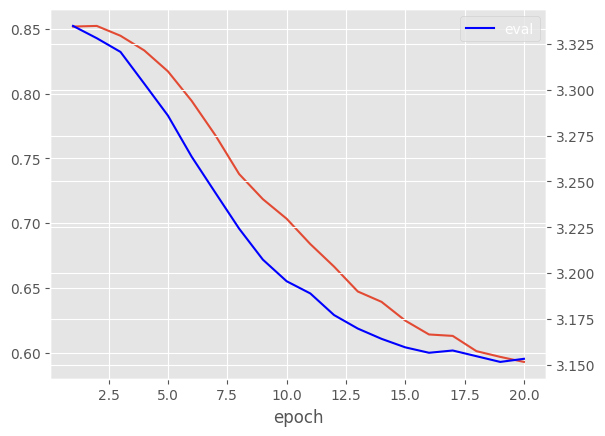

In [20]:
# example training
df_hist = data[-1]['hist']#.groupby('epoch').last().dropna(axis=1).drop(columns=['step'])
df_hist['loss'].plot(label='train')
plt.twinx()
df_hist['eval_loss'].plot(c='b', label='eval')
plt.legend()
plt.show()

<Axes: xlabel='epoch'>

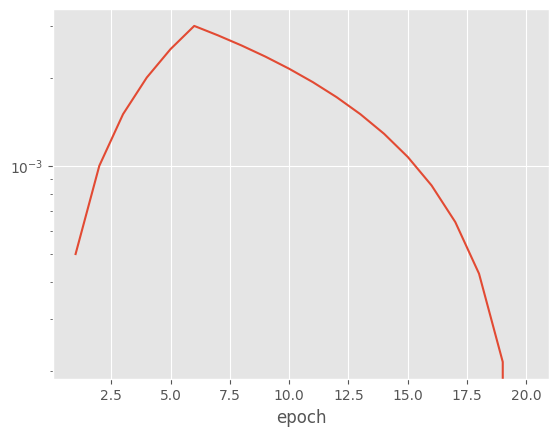

In [21]:
df_hist['learning_rate'].plot(logy=True)


### Perplexity

Perplexity measures how well a language model predicts a text sample. Lower is better

It’s calculated as the average number of bits per word a model needs to represent the same

https://huggingface.co/docs/transformers/perplexity
https://thegradient.pub/understanding-evaluation-metrics-for-language-models/

The **improvement** column, is perplexity decrease

In [22]:
df_res = pd.DataFrame(data)
df_res['len'] = df_res.content.str.len()
df_res = df_res[['before', 'after', 'title',  'len']].set_index('title')
df_res['improvement%'] = (df_res['before'] - df_res['after'])/ df_res['before']
df_res['improvement'] = (df_res['before'] - df_res['after'])
df_res['novel'] = df_res['before'] > 15
df_res['learnable'] = df_res['improvement%'] > 0.02

# We can measure the final score using learnable * novel
# df_res['BS'] = ~df_res['learnable'] | ~df_res['novel']
# Or just absolute perplexity improvement
df_res['BS'] = df_res['improvement'] < 1
df_res = df_res.sort_values('improvement', ascending=False)
df_res

,before,after,len,improvement%,improvement,novel,learnable,BS
title,,,,,,,,
How to Catch an AI Liar,28.927479,23.912350,5464,0.173369,5.015129,True,True,False
"ibois, Philippe (2012-06-03).",72.714935,63.473969,13707,0.127085,9.240967,True,True,False
buzzfeed foi fauci emails 2023,23.320093,20.782446,13640,0.108818,2.537647,True,True,False
disney appointment,118.502907,110.344528,3653,0.068845,8.158379,True,True,False
blechley declaration,17.862339,16.786160,7762,0.060249,1.076180,True,True,False
fake ai hoax paper,7.748084,7.473690,3290,0.035414,0.274394,False,True,True
harvard announcment caplain israel hamas,45.436657,44.633602,4247,0.017674,0.803055,True,False,True


In [23]:
print(df_res.to_markdown())

| title                                    |    before |     after |   len |   improvement% |   improvement | novel   | learnable   | BS    |
|:-----------------------------------------|----------:|----------:|------:|---------------:|--------------:|:--------|:------------|:------|
| How to Catch an AI Liar                  |  28.9275  |  23.9123  |  5464 |      0.173369  |      5.01513  | True    | True        | False |
| ibois, Philippe (2012-06-03).            |  72.7149  |  63.474   | 13707 |      0.127085  |      9.24097  | True    | True        | False |
| buzzfeed foi fauci emails 2023           |  23.3201  |  20.7824  | 13640 |      0.108818  |      2.53765  | True    | True        | False |
| disney appointment                       | 118.503   | 110.345   |  3653 |      0.0688454 |      8.15838  | True    | True        | False |
| blechley declaration                     |  17.8623  |  16.7862  |  7762 |      0.0602485 |      1.07618  | True    | True        | False |
| fake

# DEBUG

In [39]:
from IPython.display import display, HTML, Markdown
import torch

@torch.no_grad()
def gen(model, inputs, tokenizer, clean=True):
    s = model.generate(
        input_ids=inputs["input_ids"][None, :].to(model.device),
        attention_mask=inputs["attention_mask"][None, :].to(model.device),
        use_cache=False,
        max_new_tokens=100,
        min_new_tokens=100,
        do_sample=False,
        early_stopping=False,
    )
    input_l = inputs["input_ids"].shape[0]
    tokenizer_kwargs=dict(clean_up_tokenization_spaces=clean, skip_special_tokens=clean)
    old = tokenizer.decode(
        s[0, :input_l][-100:], **tokenizer_kwargs
    )
    new = tokenizer.decode(
        s[0, input_l:], **tokenizer_kwargs
    )
    s_old = ""+old.replace('\n', '<br>')
    s_new =  '<b>' + new.replace('\n', '<br>')+ '<br><br><b/>'
    # print(s_old, s_new)
    display(HTML(f"{s_old}{s_new}"))
    # print([old, new])



In [40]:
sample = samples[-1]
s = sample['content']
first_half = s[:len(s)//2]
second_half = s[len(s)//2:]
ds_train = Dataset.from_dict(tokenizer([first_half]))
ds_val = Dataset.from_dict(tokenizer([second_half]))

In [41]:
with model.disable_adapter():
    gen(model, ds_train.with_format('pt')[0], tokenizer)

 95, 96, 97]. This is achieved through model parallelism across specialized experts, allowing the training of models with trillions of parameters, and its specialization in handling diverse data distributions enhances its capability in few-shot learning and other complex tasks [94, 95]. To illustrate the practicality of MoE, consider its application in healthcare. For example, an MoE-based system could be used for personalized medicine, where different ‘expert’ modules specialize in various aspects of patient data analysis <b>.<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><b/>


In [38]:
gen(model, ds_train.with_format('pt')[0], tokenizer)